In [3]:
!pip install langchain_community
!pip install replicate

In [4]:
import os
from google.colab import userdata

api_token = userdata.get("api_token")
os.environ["REPLICATE_API_TOKEN"] = api_token

In [5]:
from langchain_community.llms import Replicate

model_params = {
    "temperature": 0.1,
    "max_new_tokens": 512,
    "repetition_penalty": 1.1
}



llm = Replicate(
    model = "ibm-granite/granite-3.3-8b-instruct",
    model_kwargs=model_params
)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = "/content/drive/MyDrive/ColabNotebooks/Reviews.csv.zip"

!unzip "{path}"

Archive:  /content/drive/MyDrive/ColabNotebooks/Reviews.csv.zip
  inflating: Reviews.csv             


In [8]:
import pandas as pd
df = pd.read_csv("Reviews.csv")

In [9]:
# 1. Cari rating dibawah 3
df_semua_negatif = df[df['Score'] < 3].copy()
print(f"Total ulasan negatif di seluruh dataset: {len(df_semua_negatif)}")

# 2.Cari produk mana yang paling sering muncul
produk_paling_dikeluhkan = df_semua_negatif['ProductId'].value_counts()

# 3. Tampilkan 5 produk teratas yang paling banyak ulasan negatifnya
print("\nTop 5 Produk dengan Ulasan Negatif Terbanyak:")
print(produk_paling_dikeluhkan.head(5))

# 4. Ambil ID produk yang paling atas untuk dianalisis
ID_PRODUK_TARGET_BARU = produk_paling_dikeluhkan.idxmax()
print(f"\nProduk yang akan dianalisis sekarang adalah: {ID_PRODUK_TARGET_BARU}")

# 5. Lanjutkan analisis pada produk target baru ini
df_satu_produk = df[df['ProductId'] == ID_PRODUK_TARGET_BARU].copy()
df_negatif = df_satu_produk[df_satu_produk['Score'] < 3].copy()

print(f"Jumlah ulasan negatif untuk produk {ID_PRODUK_TARGET_BARU} adalah: {len(df_negatif)}")

Total ulasan negatif di seluruh dataset: 82037

Top 5 Produk dengan Ulasan Negatif Terbanyak:
ProductId
B000KV61FC    167
B000KV7ZGQ    167
B0041NYV8E    146
B005K4Q4LK    141
B005K4Q34S    141
Name: count, dtype: int64

Produk yang akan dianalisis sekarang adalah: B000KV61FC
Jumlah ulasan negatif untuk produk B000KV61FC adalah: 167


In [10]:
# Ambil 3 ulasan pertama dari kolom 'Text'
sampel_ulasan = df_satu_produk['Text'].head(3).tolist()

# Gabungkan 3 ulasan
konteks_ulasan = "\n\n---\n\n".join(sampel_ulasan)

In [11]:
def create_product_id_prompt(konteks):
    prompt = f"""
    Tugas: Berdasarkan kumpulan ulasan pelanggan berikut, apa nama atau jenis produk yang paling mungkin sedang dibicarakan? Jawab dengan nama produk atau jenisnya secara singkat dan jelas.

    Kumpulan Ulasan:
    {konteks}

    Nama atau Jenis Produk yang Paling Mungkin:
    """
    return prompt

In [12]:
# Menemukan produk sesuai generate Ai
prompt_identifikasi = create_product_id_prompt(konteks_ulasan)

# Panggil model AI
nama_produk_hasil_ai = llm.invoke(prompt_identifikasi)

print(f"ID Produk: {ID_PRODUK_TARGET_BARU}")
print(f"Hasil identifikasi AI: Produk ini kemungkinan adalah -> {nama_produk_hasil_ai.strip()}")

ID Produk: B000KV61FC
Hasil identifikasi AI: Produk ini kemungkinan adalah -> The product being discussed is the "Tug-a-Jug." It's a dog toy designed for interactive play, training, and feeding. It consists of a rubber bottle with holes along its body, allowing treats or kibble to fall out as the dog bats it around.


In [13]:
def create_dog_toy_prompt(ulasan_teks):
    # Kategori keluhan
    kategori_keluhan = "Daya Tahan & Kualitas, Desain & Fungsi, Keamanan Produk, Minat Anjing, Harga"

    # Instruksi
    prompt = f"""
    Tugas: Analisis ulasan pelanggan tentang mainan anjing "Tug-a-jug" berikut. Tentukan kategori keluhan utamanya.
    Pilih SATU kategori paling dominan dari daftar ini:
    - Daya Tahan & Kualitas (misal: mudah hancur, rusak digigit, material jelek, pecah)
    - Desain & Fungsi (misal: makanan sulit keluar, terlalu mudah keluar, sulit dibersihkan, ukuran tidak pas)
    - Keamanan Produk (misal: bagian kecil copot, berbahaya jika tertelan, material beracun)
    - Minat Anjing (misal: anjing tidak suka, takut dengan mainan, tidak mau pakai)
    - Harga (misal: terlalu mahal, tidak sepadan)

    Ulasan Pelanggan: "{ulasan_teks}"

    Kategori Keluhan:
    """
    return prompt

In [14]:
import time

hasil_analisis = []

print("Memulai analisis dengan AI...")
for index, baris in df_negatif.iterrows():

    teks_ulasan = baris['Text']

    # Buat prompt dengan fungsi yang kita buat
    prompt_untuk_ai = create_dog_toy_prompt(teks_ulasan)

    try:
        # Panggil model AI dengan prompt
        response = llm.invoke(prompt_untuk_ai)

        # Tambahkan hasil (response) ke dalam list
        hasil_analisis.append(response.strip())
        print(f"Ulasan ke-{index+1} selesai dianalisis. Kategori: {response.strip()}")

    except Exception as e:
        # Jika ada error dari API, kita catat sebagai 'Gagal'
        print(f"Error pada ulasan ke-{index+1}: {e}")
        hasil_analisis.append("Gagal Analisis")

    time.sleep(0.5) # Beri jeda 0.5 detik

# Tambahkan hasil analisis sebagai kolom baru di dataframe
df_negatif['Kategori'] = hasil_analisis

print("\nAnalisis selesai! Hasilnya sudah ditambahkan ke dataframe.")
print(df_negatif[['Text', 'Kategori']].head())

Memulai analisis dengan AI...
Ulasan ke-21739 selesai dianalisis. Kategori: Desain & Fungsi

The main complaint in the customer review revolves around the usability and functionality of the Tug-a-Jug toy. The customer mentions that their 20-lb Papillon dog struggled to understand how to use the toy, despite being highly motivated by food. This indicates an issue with the toy's design making it difficult for the dog to engage with it independently. The customer also notes that they eventually had to assist their dog, implying that the toy's intended function was not effectively met. Therefore, the dominant category for this complaint is Desain & Fungsi (Design & Function).
Ulasan ke-21747 selesai dianalisis. Kategori: Based on the customer review, the primary category of complaint for the "Tug-a-jug" dog toy is "Daya Tahan & Kualitas" (Durability & Quality). The customer mentions that their dog managed to destroy the toy within 4 hours, the rubber rope didn't withstand chewing, and the 

In [15]:
# Hitung jumlah ulasan untuk setiap kategori
jumlah_per_kategori = df_negatif['Kategori'].value_counts()

# Ambil 2 kategori teratas
top_2_keluhan = jumlah_per_kategori.head(2)

print("--- Top2 Keluhan Utama Pelanggan ---")
print(top_2_keluhan)

--- Top2 Keluhan Utama Pelanggan ---
Kategori
Desain & Fungsi\n\nThe main complaint in the customer review revolves around the usability and functionality of the Tug-a-Jug toy. The customer mentions that their 20-lb Papillon dog struggled to understand how to use the toy, despite being highly motivated by food. This indicates an issue with the toy's design making it difficult for the dog to engage with it independently. The customer also notes that they eventually had to assist their dog, implying that the toy's intended function was not effectively met. Therefore, the dominant category for this complaint is Desain & Fungsi (Design & Function).    1
Based on the customer review, the primary category of complaint for the "Tug-a-jug" dog toy is "Daya Tahan & Kualitas" (Durability & Quality). The customer mentions that their dog managed to destroy the toy within 4 hours, the rubber rope didn't withstand chewing, and the design caused the jug to be bulky and easily knocked around by the do

In [16]:
# 1. Siapkan ringkasan temuan untuk diberikan kepada AI

ringkasan_temuan = ""
for kategori, jumlah in top_2_keluhan.items():
    ringkasan_temuan += f"- {kategori} (disebutkan dalam {jumlah} ulasan negatif)\n"

# 2. Buat fungsi prompt untuk meminta rekomendasi
def create_recommendation_prompt(product_name, summary):
    prompt = f"""
    Tugas: Anda adalah seorang Product Manager Analyst yang berpengalaman.
    Produk yang sedang dianalisis adalah mainan anjing bernama "{product_name}".

    Berdasarkan analisis sentimen terhadap ulasan negatif pelanggan, ditemukan 2 masalah utama sebagai berikut:
    {summary}

    Berdasarkan 2 masalah utama tersebut, berikan rekomendasi yang konkret dan bisa ditindaklanjuti (actionable) untuk tim pengembangan produk.
    Sajikan dalam format poin-poin untuk setiap kategori masalah.

    Contoh Jawaban:
    Rekomendasi untuk Tim Produk:
    1.  **Terkait [Kategori Masalah 1]:**
        * [Rekomendasi spesifik 1A]
        * [Rekomendasi spesifik 1B]
    2.  **Terkait [Kategori Masalah 2]:**
        * [Rekomendasi spesifik 2A]

    Rekomendasi Anda:
    """
    return prompt

# 3. Panggil AI untuk mendapatkan rekomendasi strategis

nama_produk = "Tug-a-jug"
prompt_rekomendasi = create_recommendation_prompt(nama_produk, ringkasan_temuan)

rekomendasi_final = llm.invoke(prompt_rekomendasi)

# 4. Tampilkan hasil akhir
print("\n--- Rekomendasi Strategis dari AI untuk Tim Produk ---")
print(rekomendasi_final.strip())


--- Rekomendasi Strategis dari AI untuk Tim Produk ---
1. **Terkait Desain & Fungsi:**
   - *1A* Conduct user testing with a diverse range of dog breeds and sizes to identify any design flaws that hinder independent use.
   - *1B* Simplify the toy's design to make it more intuitive for dogs to understand and engage with, possibly by adding visual or tactile cues.

2. **Terkait Daya Tahan & Kualitas:**
   - *2A* Source higher-quality, more durable materials for the rubber rope and jug component to withstand aggressive chewing.
   - *2B* Redesign the jug to be more compact and stable, reducing the likelihood of it being knocked over during play.

These actionable recommendations aim to address the main issues of usability, functionality, durability, and quality, ultimately improving the Tug-a-Jug dog toy and enhancing customer satisfaction.


In [17]:
# membersihkan kategori
def bersihkan_kategori(jawaban_ai):

    kategori_valid = ["Daya Tahan & Kualitas", "Desain & Fungsi", "Keamanan Produk", "Minat Anjing", "Harga"]

    for kategori in kategori_valid:

        if kategori in jawaban_ai:
            return kategori

    return "Tidak Terkategori"

In [18]:

df_negatif['Kategori_Bersih'] = df_negatif['Kategori'].apply(bersihkan_kategori)

print("--- Hasil Setelah Pembersihan ---")
print(df_negatif['Kategori_Bersih'].value_counts())

--- Hasil Setelah Pembersihan ---
Kategori_Bersih
Daya Tahan & Kualitas    84
Desain & Fungsi          48
Minat Anjing             32
Keamanan Produk           3
Name: count, dtype: int64


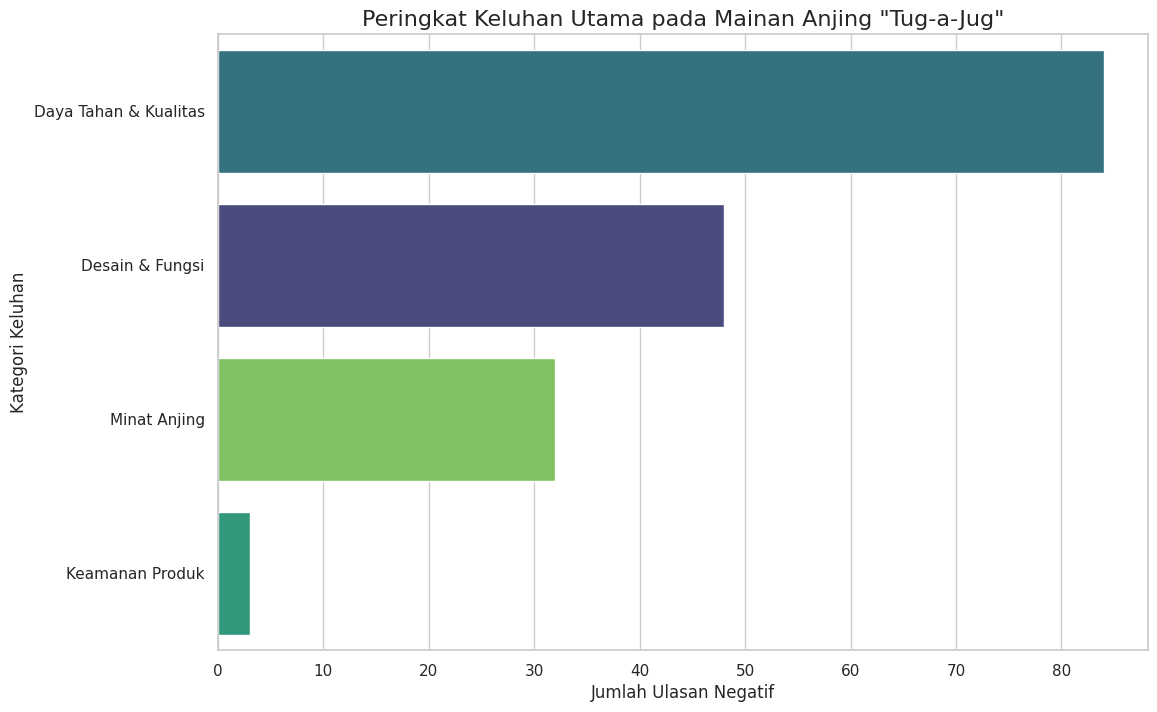

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

grafik = sns.countplot(
    y='Kategori_Bersih',
    data=df_negatif,
    order=df_negatif['Kategori_Bersih'].value_counts().index,
    palette='viridis',
    hue='Kategori_Bersih',
    legend=False
)

grafik.set_title('Peringkat Keluhan Utama pada Mainan Anjing "Tug-a-Jug"', fontsize=16)
grafik.set_xlabel('Jumlah Ulasan Negatif', fontsize=12)
grafik.set_ylabel('Kategori Keluhan', fontsize=12)

plt.show()